In [ ]:
# Copyright 2023 DeepMind Technologies Limited
#
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
#    http://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.
# ==============================================================================

This notebook computes clusters based on sequence similarity and writes the dataframe out to disk.

This notebook is quite slow, and can take ~2hrs to compute all the clusterings for G1.


# Imports

In [ ]:
!pip install --upgrade https://github.com/google-deepmind/nuclease-design.git


In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns

from nuclease_design import utils
from nuclease_design import constants
from nuclease_design import plotting


# Constants

In [ ]:
DATA_DIR = constants.DATA_DIR

In [ ]:
OVERWRITE = True  # Setting this to True will rewrite all cluster files

# Set this to <<1.0 when debugging.
SUBSAMPLE_FRACTION = 1.0

# Set to narrow range e.g. (23, 24) when debugging
MIN_CLUSTER_RADIUS_G4 = 0
MAX_CLUSTER_RADIUS_G4 = 26

# Set to narrow range e.g. (15, 16) when debugging
MIN_CLUSTER_RADIUS_G1 = 0
MAX_CLUSTER_RADIUS_G1 = 21

In [ ]:
sns.set(font_scale=2)
sns.set_style('ticks')

# Library code

In [ ]:
def _get_bootstrapped_num_clusters(
    df,
    filter_fn,
    max_intra_cluster_hamming_distance,
    num_bootstraps=10,
    random_seed=0,
):
  random_state = np.random.RandomState(random_seed)
  samples = [
      utils.num_sequence_clusters(
          filter_fn(
              df.sample(frac=1.0, random_state=random_state, replace=True),
          )['sequence'],
          max_intra_cluster_hamming_distance=max_intra_cluster_hamming_distance,
      )
      for _ in range(num_bootstraps)
  ]
  return pd.DataFrame(dict(num_clusters=samples))


def _get_activity_label(reference_name):
  if reference_name == 'all':
    return 'all'
  activity_label = utils.get_activity_label(reference_name)
  return f'> {activity_label}'

def get_num_clusters_df(
    df,
    hit_calling_kwargs_list,
    max_intra_cluster_hamming_distance,
    hue_feature='sequence_type',

):
  hit_calling_kwargs_list = [dict(reference_name='all')] + hit_calling_kwargs_list
  num_clusters_dfs = []
  for hit_calling_kwargs in hit_calling_kwargs_list:
    reference_name = hit_calling_kwargs['reference_name']
    filter_fn = (
        lambda df: utils.select_hit_rows(df, **hit_calling_kwargs)
        if reference_name != 'all'
        else df
    )
    activity_label = _get_activity_label(reference_name)
    num_clusters_dfs.append(
        df.groupby(hue_feature)
        .apply(
            _get_bootstrapped_num_clusters,
            filter_fn=filter_fn,
            max_intra_cluster_hamming_distance=max_intra_cluster_hamming_distance,
        )
        .reset_index()
        .assign(activity_label=activity_label)
    )
  num_clusters_df = pd.concat(num_clusters_dfs, ignore_index=True)
  num_clusters_df['max_intra_cluster_hamming_distance'] = max_intra_cluster_hamming_distance
  return num_clusters_df

# Load data

In [ ]:
all_data_df = utils.load_all_data(DATA_DIR)
df = utils.expand_sublibraries(all_data_df)
df['campaign'] = df['sublibrary_name'].apply(lambda s: 'HR' if s.endswith('recombination') else 'ML')

# G4 MBO_DNN vs. Baseline

In [ ]:
g4_comparison_df = df[df['sublibrary_name'].isin(['g4_mbo_dnn', 'g4_hit_recombination'])]

In [ ]:
%%time
hit_calling_kwargs_list = [
    dict(reference_name='neg_control', expected_false_discovery_rate=utils.EXPECTED_FDR),
    dict(reference_name='wt', expected_false_discovery_rate=utils.EXPECTED_FDR),
    dict(reference_name='a73r', expected_false_discovery_rate=utils.EXPECTED_FDR),
]


all_dfs = []
for distance in range(MIN_CLUSTER_RADIUS_G4, MAX_CLUSTER_RADIUS_G4):
  num_clusters_df = get_num_clusters_df(
      g4_comparison_df,
      hit_calling_kwargs_list,
      hue_feature='campaign',
      max_intra_cluster_hamming_distance=distance,
  )
  all_dfs.append(num_clusters_df)
num_clusters_g4_df = pd.concat(all_dfs, ignore_index=True)

# add pre-sort label
num_clusters_g4_df['activity_label'] = num_clusters_g4_df['activity_label'].apply(lambda x: 'pre-sort' if x == 'all' else x)

# rename
num_clusters_g4_df['population'] = num_clusters_g4_df['activity_label'].astype(str)
num_clusters_g4_df['population'] = num_clusters_g4_df['population'].str.replace('a73r', 'A73R')
num_clusters_g4_df['population'] = num_clusters_g4_df['population'].str.replace('neg_control', 'negative control')
num_clusters_g4_df['population'] = num_clusters_g4_df['population'].str.replace('wt', 'parent')

CPU times: user 4min 24s, sys: 7.64 s, total: 4min 31s
Wall time: 4min 27s


In [ ]:
if OVERWRITE:
  with utils.open_file(constants.NUM_CLUSTERS_G4_PATH, 'w', DATA_DIR) as f:
    num_clusters_g4_df.to_csv(f, index=False)

In [ ]:
num_clusters_g4_df.head()

,campaign,level_1,num_clusters,activity_label,max_intra_cluster_hamming_distance,population
0,HR,0,979,pre-sort,0,pre-sort
1,HR,1,958,pre-sort,0,pre-sort
2,HR,2,972,pre-sort,0,pre-sort
3,HR,3,980,pre-sort,0,pre-sort
4,HR,4,952,pre-sort,0,pre-sort


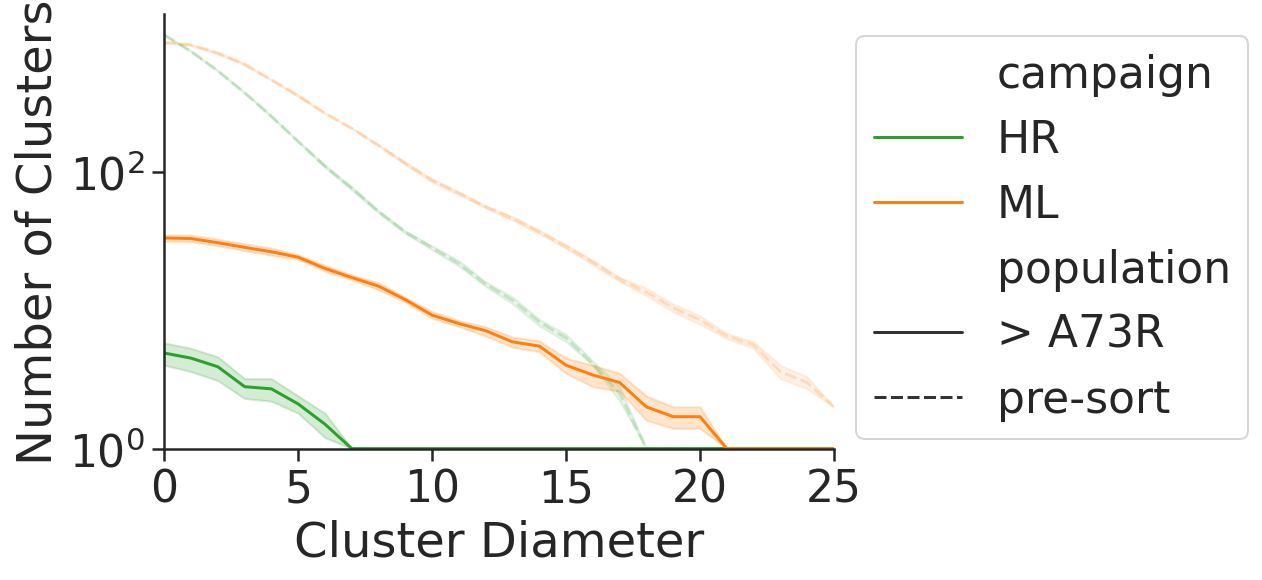

In [ ]:
# sanity check with plot
plotting.make_diversity_overlay_plot(
    num_clusters_g4_df, '> A73R', 'campaign', ['HR', 'ML'],
    palette=[plotting.HR_COLOR, plotting.ML_COLOR],
)

# Zero-shot

In [ ]:
g1_df = df[df.generation == 'g1'].reset_index(drop=True)
subsample_g1_df = g1_df.sample(frac=SUBSAMPLE_FRACTION)
zero_shot_comparison_df = pd.concat([df[df['sublibrary_name'] == 'zero_shot'], subsample_g1_df])

In [ ]:
%%time
hit_calling_kwargs_list = [
    dict(reference_name='neg_control', expected_false_discovery_rate=utils.EXPECTED_FDR),
    dict(reference_name='wt', expected_false_discovery_rate=utils.EXPECTED_FDR),
]

all_dfs = []
for distance in range(MIN_CLUSTER_RADIUS_G1, MAX_CLUSTER_RADIUS_G1):
  num_clusters_df = get_num_clusters_df(
      zero_shot_comparison_df,
      hit_calling_kwargs_list,
      hue_feature='sublibrary_name',
      max_intra_cluster_hamming_distance=distance,
  )
  all_dfs.append(num_clusters_df)
num_clusters_zero_shot_df = pd.concat(all_dfs, ignore_index=True)
# add pre-sort label
num_clusters_zero_shot_df['activity_label'] = num_clusters_zero_shot_df['activity_label'].apply(lambda x: 'pre-sort' if x == 'all' else x)

# rename activity_label to population
num_clusters_zero_shot_df['population'] = num_clusters_zero_shot_df['activity_label'].astype(str)
num_clusters_zero_shot_df['population'] = num_clusters_zero_shot_df['population'].str.replace('a73r', 'A73R')
num_clusters_zero_shot_df['population'] = num_clusters_zero_shot_df['population'].str.replace('neg_control', 'negative control')
num_clusters_zero_shot_df['population'] = num_clusters_zero_shot_df['population'].str.replace('wt', 'parent')

CPU times: user 38min 4s, sys: 2min 21s, total: 40min 25s
Wall time: 40min 3s


In [ ]:
if OVERWRITE:
  with utils.open_file(constants.NUM_CLUSTERS_ZERO_SHOT_PATH, 'w', DATA_DIR) as f:
    num_clusters_zero_shot_df.to_csv(f, index=False)

In [ ]:
num_clusters_zero_shot_df.head()

,sublibrary_name,level_1,num_clusters,activity_label,max_intra_cluster_hamming_distance,population
0,g1_eppcr,0,5990,pre-sort,0,pre-sort
1,g1_eppcr,1,5981,pre-sort,0,pre-sort
2,g1_eppcr,2,5889,pre-sort,0,pre-sort
3,g1_eppcr,3,5961,pre-sort,0,pre-sort
4,g1_eppcr,4,5977,pre-sort,0,pre-sort


In [ ]:
# sanity check with plot

plotting.make_diversity_overlay_plot(
    num_clusters_zero_shot_df,
    '> negative control',
    'sublibrary_name',
    ['g1_eppcr', 'zero_shot'],
    palette=[plotting.EPPCR_COLOR, plotting.ML_COLOR],
    xticks_max=21,
)